In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


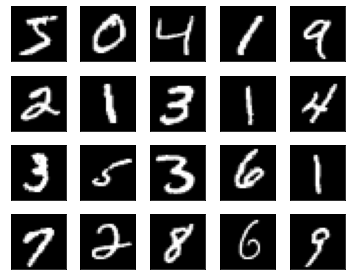

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

##Preprocessing and Deprocessing


In [4]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

##Generator


In [6]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    return Sequential([
        # FC 1: 7,7,16
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 1: 14,14,32
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 28,28,1
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

##Discriminator


In [7]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        # Conv 1: 14,14,32
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 7,7,16
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # FC 1
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Output
        Dense(1),
        Activation('sigmoid')        
    ])

##DCGAN


In [8]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear first
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

##Training DCGAN


In [9]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [11]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [12]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [13]:
def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [14]:
def train(
    g_learning_rate,   # learning rate for the generator
    g_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate,   # learning rate for the discriminator
    d_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,        # label smoothing
    sample_size=100,   # latent sample size (i.e. 100 random numbers)
    epochs=100,
    batch_size=128,    # train batch size
    eval_size=16,      # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

Epoch:  1/100 Discriminator Loss:16.3516 Generator Loss: 0.0205
Epoch:  2/100 Discriminator Loss:13.9161 Generator Loss: 0.0015
Epoch:  3/100 Discriminator Loss:13.9204 Generator Loss: 0.2365
Epoch:  4/100 Discriminator Loss:11.2694 Generator Loss: 5.7603
Epoch:  5/100 Discriminator Loss: 6.5541 Generator Loss: 5.1513
Epoch:  6/100 Discriminator Loss: 1.5049 Generator Loss:16.7607
Epoch:  7/100 Discriminator Loss: 0.2669 Generator Loss: 7.1291
Epoch:  8/100 Discriminator Loss: 0.0984 Generator Loss: 4.3202
Epoch:  9/100 Discriminator Loss: 4.7315 Generator Loss: 3.1169
Epoch: 10/100 Discriminator Loss: 3.2593 Generator Loss: 3.3124


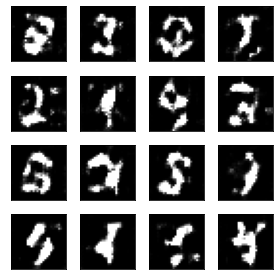

Epoch: 11/100 Discriminator Loss: 3.0096 Generator Loss: 2.3904
Epoch: 12/100 Discriminator Loss: 1.6375 Generator Loss: 1.7971
Epoch: 13/100 Discriminator Loss: 1.3450 Generator Loss: 1.4744
Epoch: 14/100 Discriminator Loss: 2.1095 Generator Loss: 3.3573
Epoch: 15/100 Discriminator Loss: 2.1260 Generator Loss: 2.6807
Epoch: 16/100 Discriminator Loss: 1.7459 Generator Loss: 1.3551
Epoch: 17/100 Discriminator Loss: 2.1407 Generator Loss: 1.6730
Epoch: 18/100 Discriminator Loss: 3.1146 Generator Loss: 4.1062
Epoch: 19/100 Discriminator Loss: 1.2229 Generator Loss: 1.6379
Epoch: 20/100 Discriminator Loss: 4.3565 Generator Loss: 4.4869


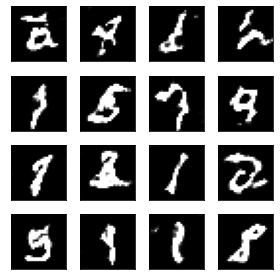

Epoch: 21/100 Discriminator Loss: 1.0973 Generator Loss: 1.1763
Epoch: 22/100 Discriminator Loss: 1.6639 Generator Loss: 2.0768
Epoch: 23/100 Discriminator Loss: 2.6698 Generator Loss: 3.4273
Epoch: 24/100 Discriminator Loss: 1.6114 Generator Loss: 2.0589
Epoch: 25/100 Discriminator Loss: 1.2864 Generator Loss: 0.9824
Epoch: 26/100 Discriminator Loss: 1.7705 Generator Loss: 1.1468
Epoch: 27/100 Discriminator Loss: 1.9596 Generator Loss: 1.2972
Epoch: 28/100 Discriminator Loss: 2.7699 Generator Loss: 3.8747
Epoch: 29/100 Discriminator Loss: 1.3944 Generator Loss: 1.5258
Epoch: 30/100 Discriminator Loss: 5.6902 Generator Loss: 5.6080


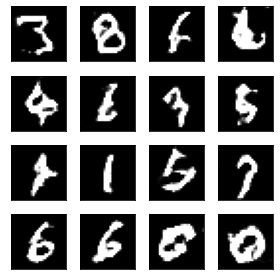

Epoch: 31/100 Discriminator Loss: 1.2273 Generator Loss: 0.7901
Epoch: 32/100 Discriminator Loss: 3.4946 Generator Loss: 2.2630
Epoch: 33/100 Discriminator Loss: 1.6058 Generator Loss: 1.7813
Epoch: 34/100 Discriminator Loss: 1.3296 Generator Loss: 0.5599
Epoch: 35/100 Discriminator Loss: 3.3505 Generator Loss: 4.0939
Epoch: 36/100 Discriminator Loss: 1.2370 Generator Loss: 1.5895
Epoch: 37/100 Discriminator Loss: 3.0047 Generator Loss: 3.8158
Epoch: 38/100 Discriminator Loss: 1.3315 Generator Loss: 1.1178
Epoch: 39/100 Discriminator Loss: 2.2058 Generator Loss: 2.5285
Epoch: 40/100 Discriminator Loss: 1.2898 Generator Loss: 1.2020


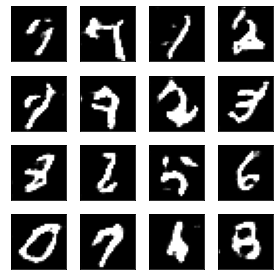

Epoch: 41/100 Discriminator Loss: 1.3235 Generator Loss: 1.3442
Epoch: 42/100 Discriminator Loss: 1.3735 Generator Loss: 1.4163
Epoch: 43/100 Discriminator Loss: 3.5949 Generator Loss: 3.8932
Epoch: 44/100 Discriminator Loss: 2.2582 Generator Loss: 2.7139
Epoch: 45/100 Discriminator Loss: 4.0926 Generator Loss: 4.4611
Epoch: 46/100 Discriminator Loss: 0.9083 Generator Loss: 1.3785
Epoch: 47/100 Discriminator Loss: 1.3109 Generator Loss: 1.3345
Epoch: 48/100 Discriminator Loss: 1.1153 Generator Loss: 1.3560
Epoch: 49/100 Discriminator Loss: 1.5249 Generator Loss: 0.9770
Epoch: 50/100 Discriminator Loss: 1.2555 Generator Loss: 1.2912


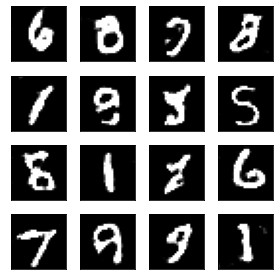

Epoch: 51/100 Discriminator Loss: 1.9171 Generator Loss: 2.3919
Epoch: 52/100 Discriminator Loss: 1.0521 Generator Loss: 1.4818
Epoch: 53/100 Discriminator Loss: 1.3871 Generator Loss: 2.0165
Epoch: 54/100 Discriminator Loss: 2.8001 Generator Loss: 2.7791
Epoch: 55/100 Discriminator Loss: 3.6122 Generator Loss: 3.6803
Epoch: 56/100 Discriminator Loss: 1.8855 Generator Loss: 1.9016
Epoch: 57/100 Discriminator Loss: 3.3590 Generator Loss: 3.9236
Epoch: 58/100 Discriminator Loss: 1.1425 Generator Loss: 1.0998
Epoch: 59/100 Discriminator Loss: 1.6596 Generator Loss: 2.0749
Epoch: 60/100 Discriminator Loss: 1.2215 Generator Loss: 2.2421


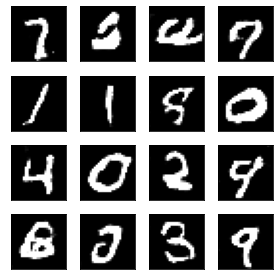

Epoch: 61/100 Discriminator Loss: 1.1411 Generator Loss: 1.2660
Epoch: 62/100 Discriminator Loss: 2.7479 Generator Loss: 2.6673
Epoch: 63/100 Discriminator Loss: 1.5412 Generator Loss: 0.8125
Epoch: 64/100 Discriminator Loss: 2.0311 Generator Loss: 2.1774
Epoch: 65/100 Discriminator Loss: 1.9745 Generator Loss: 2.3634
Epoch: 66/100 Discriminator Loss: 1.6291 Generator Loss: 1.0782
Epoch: 67/100 Discriminator Loss: 1.6124 Generator Loss: 1.6921
Epoch: 68/100 Discriminator Loss: 2.9972 Generator Loss: 2.8374
Epoch: 69/100 Discriminator Loss: 1.9222 Generator Loss: 1.8089
Epoch: 70/100 Discriminator Loss: 1.5108 Generator Loss: 1.1376


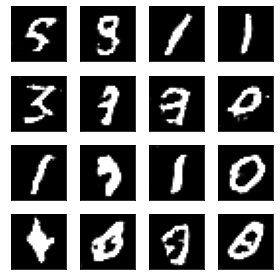

Epoch: 71/100 Discriminator Loss: 3.3309 Generator Loss: 3.8107
Epoch: 72/100 Discriminator Loss: 1.9869 Generator Loss: 2.5250
Epoch: 73/100 Discriminator Loss: 1.6817 Generator Loss: 0.8329
Epoch: 74/100 Discriminator Loss: 1.4525 Generator Loss: 1.2907
Epoch: 75/100 Discriminator Loss: 3.2948 Generator Loss: 3.7376
Epoch: 76/100 Discriminator Loss: 2.0007 Generator Loss: 1.4546
Epoch: 77/100 Discriminator Loss: 3.2501 Generator Loss: 3.7166
Epoch: 78/100 Discriminator Loss: 4.2688 Generator Loss: 5.2865
Epoch: 79/100 Discriminator Loss: 2.9842 Generator Loss: 3.1187
Epoch: 80/100 Discriminator Loss: 2.4515 Generator Loss: 3.0704


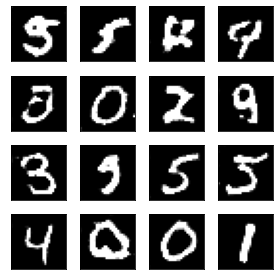

Epoch: 81/100 Discriminator Loss: 1.6761 Generator Loss: 2.2176
Epoch: 82/100 Discriminator Loss: 3.3020 Generator Loss: 1.7638
Epoch: 83/100 Discriminator Loss: 1.6842 Generator Loss: 1.7247
Epoch: 84/100 Discriminator Loss: 1.0377 Generator Loss: 0.9472
Epoch: 85/100 Discriminator Loss: 2.1897 Generator Loss: 2.3748
Epoch: 86/100 Discriminator Loss: 1.2357 Generator Loss: 1.3724
Epoch: 87/100 Discriminator Loss: 1.8513 Generator Loss: 2.2299
Epoch: 88/100 Discriminator Loss: 2.1567 Generator Loss: 2.1761
Epoch: 89/100 Discriminator Loss: 3.8761 Generator Loss: 5.0951
Epoch: 90/100 Discriminator Loss: 2.7002 Generator Loss: 3.9695


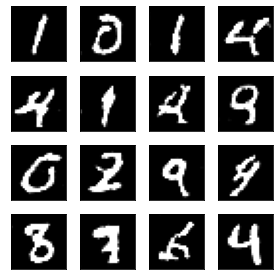

Epoch: 91/100 Discriminator Loss: 1.9805 Generator Loss: 3.3816
Epoch: 92/100 Discriminator Loss: 1.7650 Generator Loss: 3.6708
Epoch: 93/100 Discriminator Loss: 6.6330 Generator Loss: 6.3160
Epoch: 94/100 Discriminator Loss: 4.3179 Generator Loss: 3.7014
Epoch: 95/100 Discriminator Loss: 2.3679 Generator Loss: 1.4763
Epoch: 96/100 Discriminator Loss: 1.2058 Generator Loss: 1.0937
Epoch: 97/100 Discriminator Loss: 6.3564 Generator Loss: 6.6189
Epoch: 98/100 Discriminator Loss: 7.2513 Generator Loss: 5.4094
Epoch: 99/100 Discriminator Loss: 2.5374 Generator Loss: 2.4561
Epoch:100/100 Discriminator Loss: 1.9438 Generator Loss: 3.3149


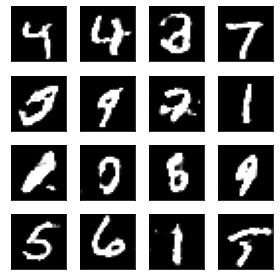

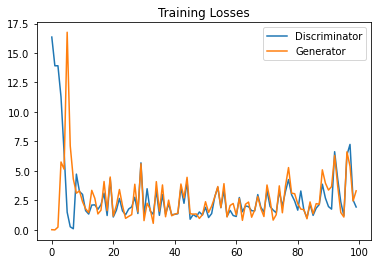

In [15]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.01);

##Reference:
https://github.com/naokishibuya/deep-learning/blob/7760cd36c2b6ea844fd2170e4d874b6c299f4ca3/python/dcgan_mnist.ipynb